<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Modeling Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

In [2]:
## General
import timeit
import re
import pandas as pd
import numpy as np
from collections import Counter

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     HalvingGridSearchCV, cross_validate)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay)

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## LightGBM
from lightgbm import LGBMClassifier

## To use S3 files
import boto3
from sagemaker import get_execution_role

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Definning S3 parameters
   </p>
</div>

In [3]:
connexion = boto3.client('s3')

In [4]:
bucket = "oc-data-scientist"
subfolder = "oc-p7/datasets/finals_datasets"
data_key = "df_current_clients.csv"

In [5]:
role = get_execution_role()
conn = boto3.client('s3')

In [6]:
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

oc-p7/datasets/finals_datasets/
oc-p7/datasets/finals_datasets/df_clients_to_predict.csv
oc-p7/datasets/finals_datasets/df_current_clients.csv


In [7]:
data_location = "s3://{}/{}/{}".format(bucket, subfolder, data_key)

<div class="alert alert-block alert-info">
    <p>Let's load the current clients
   </p>
</div>

In [8]:
df_current_clients = pd.read_csv(data_location)

In [9]:
df_analysis(df_current_clients, "df_current_clients", analysis_type="header")


Analysis Header of df_current_clients dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 1.2 GB


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>First of all, let's treat the memory to optimize its usage.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [10]:
df_current_clients = memory_optimization(df_current_clients)

In [11]:
df_analysis(df_current_clients, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 459.8 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The memory usage has been reduced.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyzing target variable</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the target variable to see whether is an imbalanced class
   </p>
</div>

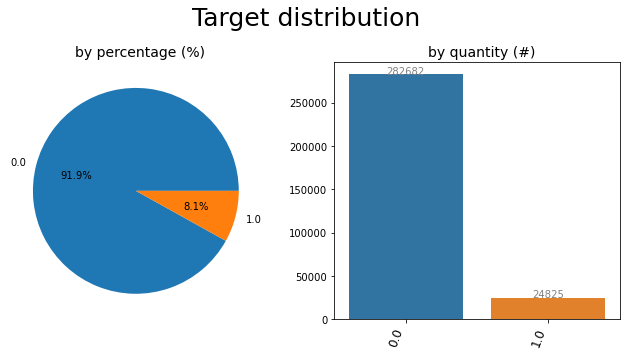

In [12]:
barplot_and_pie(df_current_clients["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Splitting data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's identify the training columns in the dataset
   </p>
</div>

In [13]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

<div class="alert alert-block alert-info">
    <p>Let's split the all data
   </p>
</div>

In [14]:
X = df_current_clients[TRAINING_COLUMNS]

In [15]:
y_target = df_current_clients.loc[:,"TARGET"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [17]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (246005, 506)
y_train: (246005,)
---------------------
X_test: (61502, 506)
y_test: (61502,)


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Modelisation initial</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to face an <b>Unbalanced Classification Problem</b> and we are going to use three models</p>
    <ul style="list-style-type: square;">
        <li>Random Forest Classifier</li>
        <li>Support Vector Machine</li>
        <li>LightGBM</li>
    </ul>
    <p>Also, we are going to use a Dummy Classifier and baseline to compare the models</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. General parameters</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to use Stratified K-Folds cross-validator to ensure that each fold of dataset has the same proportion of observations with a given label.</p>
</div>

In [27]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

<div class="alert alert-block alert-info">
    <p>Metrics to use.</p>
</div>

In [80]:
scoring = ["roc_auc", "recall", "f1"]

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Cross Validation</h3>
</div>

<div class="alert alert-block alert-info">
    <p>List of models to use. Dummy Classifier and Base line of the models</p>
</div>

In [93]:
classifiers = {
    "Dummy Classifier" : DummyClassifier(),
    "Baseline - Random Forest" : RandomForestClassifier(),
    "Baseline - LightGBM" : LGBMClassifier(),
    "Baseline - Gradient Boosting" : GradientBoostingClassifier()
}

In [94]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1, LIST_CUSTOM_SCORE, LIST_DURATION  = ([] for i in range(6))

for key, value in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    clf = value
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))
    LIST_CUSTOM_SCORE.appened(np.Nan)
    LIST_DURATION.append(end_time_model)

<div class="alert alert-block alert-info">
    <p>Dataframe to compare metrics.</p>
</div>

In [116]:
df_models_metrics = pd.DataFrame({
    "Model" : LIST_MODEL,
    "ROC-AUC" : LIST_ROC_AUC,
    "Recall" : LIST_RECALL,    
    "F1" : LIST_F1,
    "Custom Score" : LIST_CUSTOM_SCORE,
    "Duration" : LIST_DURATION,
})

In [48]:
df_models_metrics

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.989
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,516.823
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,16.852
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,1695.180


<div class="alert alert-block alert-info">
    <p>Let's transform the duration to minutes.</p>
</div>

In [100]:
df_models_metrics["Duration"] = round(df_models_metrics["Duration"]/60, 1)

In [101]:
df_models_metrics

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>it is easy to see how much time the ensembles models. Due to that, we do not consider them to plot</p>
</div>

In [118]:
COLUMNS = ["Model", "Recall", "ROC-AUC", "F1"]

In [119]:
df_models_metrics_reduced = pd.melt(df_models_metrics[COLUMNS], id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_reduced.head()

,Model,Metric,Value
0,Dummy Classifier,Recall,0.000
1,Baseline - Random Forest,Recall,0.001
2,Baseline - LightGBM,Recall,0.033
3,Baseline - Gradient Boosting,Recall,0.019
4,Dummy Classifier,ROC-AUC,0.500


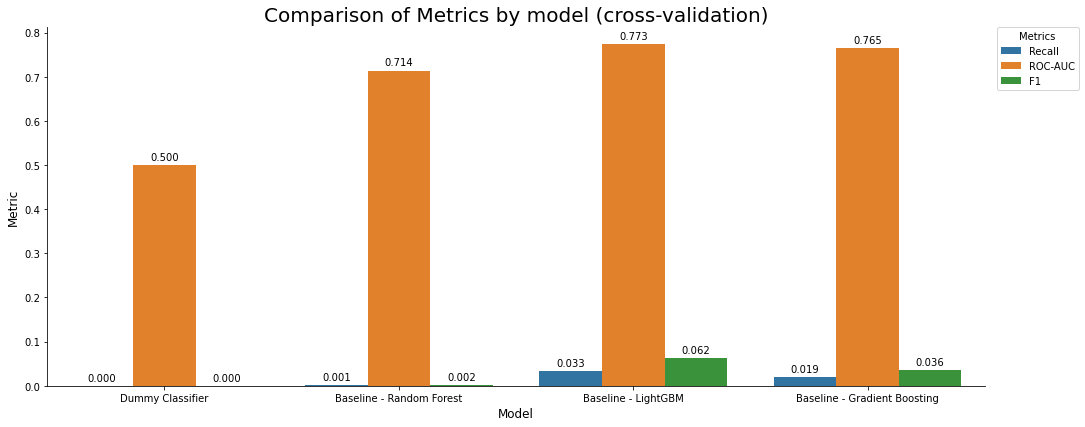

In [121]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_reduced, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (cross-validation)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)

<div class="alert alert-block alert-danger">
    <p><b>Observations / Conclusions</b></p>
    <p>it is easy to see how much time the ensembles models. Due to that, we do not consider them to plot</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Hyperparameters Tuning</h3>
</div>

<div class="alert alert-block alert-info">
    <p>For reasons of processing cost, we are going to tune the models with a subsample of the data. Done this, we will proceed to continue the modeling with the parameters obtained.</p>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.1. Subsample of the data</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to do a subsamble of the dataset to tune some parameters before the modeling
   </p>
</div>

In [13]:
df_subsample = df_current_clients.copy()

In [14]:
df_subsample = df_subsample.sample(frac=0.5)

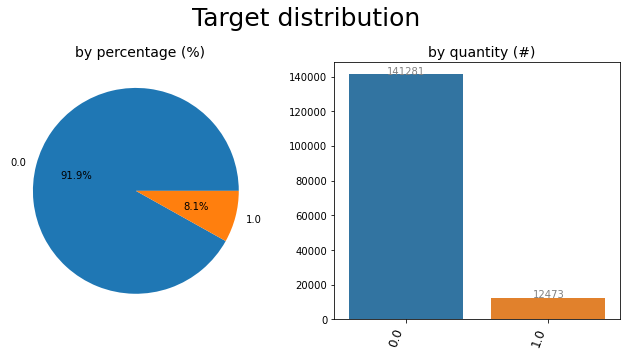

In [15]:
barplot_and_pie(df_subsample["TARGET"], "Target distribution", " ")

In [16]:
df_analysis(df_subsample, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 153754 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 231.1 MB


<div class="alert alert-block alert-info">
    <p>Now, we are going to split the subsample of the data to tune the models
   </p>
</div>

In [22]:
X_ss = df_subsample[TRAINING_COLUMNS]

In [23]:
y_target_ss = df_subsample.loc[:,"TARGET"]

In [24]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y_target_ss, test_size=0.20, stratify=y_target_ss, random_state=42)

In [25]:
print("X_train_ss: {}".format(X_train_ss.shape))
print("y_train_ss: {}".format(y_train_ss.shape))
print("---------------------")
print("X_test_ss: {}".format(X_test_ss.shape))
print("y_test_ss: {}".format(y_test_ss.shape))

X_train_ss: (123003, 506)
y_train_ss: (123003,)
---------------------
X_test_ss: (30751, 506)
y_test_ss: (30751,)


<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.2. Random Forest</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random Forest model</p>
    <p>Parameters settings</p>
</div>

In [43]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [44]:
clf_rf = RandomForestClassifier(random_state=42)

In [45]:
search_rf = HalvingGridSearchCV(clf_rf, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [46]:
search_rf.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=RandomForestClassifier(random_state=42),
                    n_jobs=-1,
                    param_grid={'max_depth': array([20, 22, 24, 26, 28]),
                                'n_estimators': array([500, 600, 700, 800, 900])})

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [47]:
search_rf.best_score_

0.9192214824028683

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [48]:
search_rf.best_params_

{'max_depth': 26, 'n_estimators': 500}

In [20]:
rf_parameters = search_rf.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.3. LightGBM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random LightGBM</p>
    <p>Parameters settings</p>
</div>

In [29]:
param_grid = {
    "n_estimators" : [8000, 10000],
    "num_leaves" : [32, 34], 
    "max_depth" : [8, 9]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [30]:
clf_lgbm = LGBMClassifier(random_state=42)

In [31]:
search_lgbm = HalvingGridSearchCV(clf_lgbm, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [32]:
search_lgbm.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                    param_grid={'max_depth': [8, 9],
                                'n_estimators': [8000, 10000],
                                'num_leaves': [32, 34]},
                    scoring='roc_auc')

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [33]:
search_lgbm.best_score_

0.7396840027850832

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [34]:
search_lgbm.best_params_

{'max_depth': 9, 'n_estimators': 8000, 'num_leaves': 32}

In [42]:
lgbm_parameters = search_lgbm.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.4. Gradient Boosting</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random LightGBM</p>
    <p>Parameters settings</p>
</div>

In [35]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model.<br>In this case, we are going to add some parameters to reduce the execution time</p>
</div>

In [36]:
clf_gb = GradientBoostingClassifier(validation_fraction=0.2, 
                                    n_iter_no_change=5,
                                    tol=0.01,
                                    random_state=42)

In [37]:
search_gb = HalvingGridSearchCV(clf_gb, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [38]:
search_gb.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=GradientBoostingClassifier(n_iter_no_change=5,
                                                         random_state=42,
                                                         tol=0.01,
                                                         validation_fraction=0.2),
                    n_jobs=-1,
                    param_grid={'max_depth': array([20, 22, 24, 26, 28]),
                                'n_estimators': array([500, 600, 700, 800, 900])},
                    scoring='roc_auc')

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [39]:
search_gb.best_score_

0.6568425917657963

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [40]:
search_gb.best_params_

{'max_depth': 20, 'n_estimators': 700}

In [54]:
gb_parameters = search_gb.best_params_

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Custom evaluations</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Threshold selection</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the predictions, we are going to identify the best treshold to mesure our models.
    </p>
</div>

In [28]:
def threshold_selection(y_train, y_prob):
    """
    Method used to calculate the threshold.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        y_train (1d array-like): True values
        y_prob (1d array-like): Probabilite values predicted
        
    Returns:
    -----------------
        threshold (float) : Best threshold value
        Threshold (image) : Plot the threshold and the best score
    """
    
    scores = []
    
    for threshold in np.linspace(0, 1, num=101):
        y_prob_value = (y_prob > threshold)*1
        score = fbeta_score(y_train, y_prob_value, beta = 2)
        scores.append(score) 

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(np.linspace(0, 1, num=101), scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Custom Score</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We need to penalize the <b>False Negative</b> that are loands <b>will be in default</b>, and they were <b>predicted incorrectly</b>.<br>Due to that, we are going to define a <b>Custom Score</b>.
    </p>
</div>

In [29]:
def custom_score(y_true, y_pred, threshold):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    y_pred = (y_pred > threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -100      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Modelisation using class_weight</h2>
</div>

<div class="alert alert-block alert-info">
    <p>At this point, we are going to use the parameter <b>class_weight</b> to affect the computation of the model to penalize differently a false classification from the minority and majority class </p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Random Forest</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's execute the model considering the parameters obtained</p>
</div>

In [21]:
clf_rf_cw = RandomForestClassifier(**rf_parameters,
                                   class_weight="balanced",
                                   random_state=42,
                                   n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [22]:
start_time_model = timeit.default_timer()

clf_rf_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [23]:
y_pred = clf_rf_cw.predict(X_test)
y_prob = clf_rf_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.11
- Best Score:		 0.414




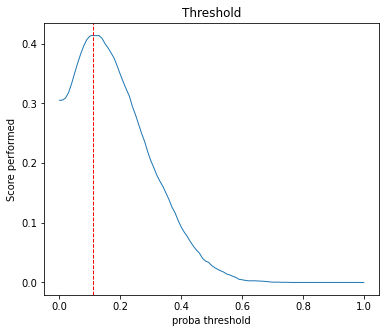

In [24]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [25]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

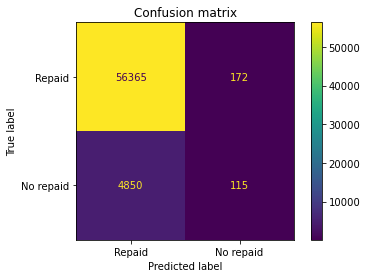

In [29]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

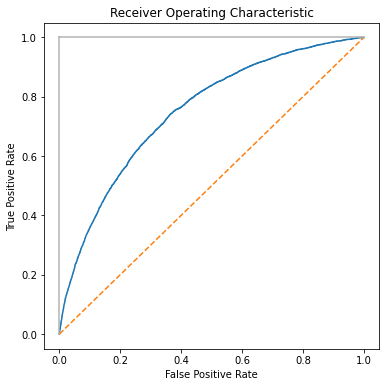

In [27]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

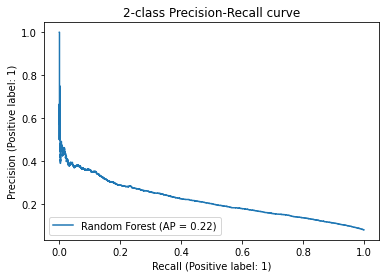

In [118]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="Random Forest")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [111]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [112]:
df_temp = pd.DataFrame({
    "Model" : ["Class weight - Random Forest"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [113]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2. LightGBM</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's execute the model considering the parameters obtained</p>
    <p>In this case, we are also going to consider the parameters used on the Kernel's Kaggle selected</p>
</div>

In [116]:
clf_lgbm_cw = LGBMClassifier(**lgbm_parameters, class_weight="balanced", learning_rate=0.02,
                             colsample_bytree=0.9497036, subsample=0.8715623,
                             reg_alpha=0.041545473, reg_lambda=0.0735294,
                             min_split_gain=0.0222415, min_child_weight=39.3259775,
                             random_state=42, n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [119]:
start_time_model = timeit.default_timer()

clf_lgbm_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [120]:
y_pred = clf_lgbm_cw.predict(X_test)
y_prob = clf_lgbm_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.3
- Best Score:		 0.439




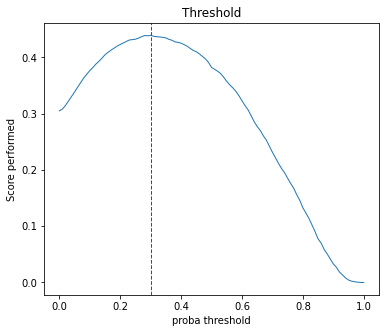

In [121]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [122]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

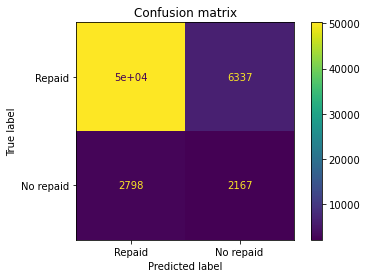

In [123]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

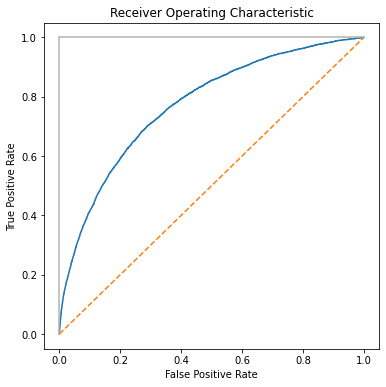

In [124]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

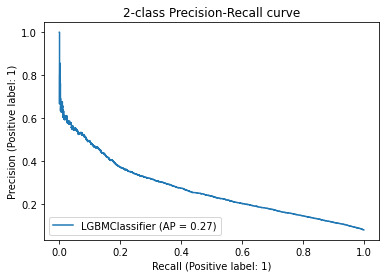

In [125]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [126]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [127]:
df_temp = pd.DataFrame({
    "Model" : ["Class weight - LightGBM"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [128]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3
5,Class weight - LightGBM,0.772,0.436,0.322,0.424,3.0


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. Gradient Boosting</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Unfortunately, Gradient Boosting (GBM) doesn't have a parameters call <b>class_weight</b> to treat with Imbalanced Class.</p>
    <p>But, GBM deals with class imbalance by constructing successive training sets based on incorrectly classified examples</p>
</div>

In [133]:
clf_gb_cw = GradientBoostingClassifier(**gb_parameters, 
                                       validation_fraction=0.2, 
                                       n_iter_no_change=5,
                                       tol=0.01, random_state=42)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [135]:
start_time_model = timeit.default_timer()

clf_gb_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [136]:
y_pred = clf_gb_cw.predict(X_test)
y_prob = clf_gb_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.06
- Best Score:		 0.35




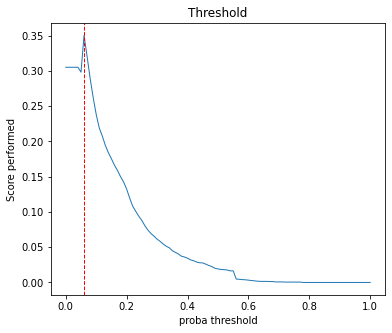

In [137]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [138]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

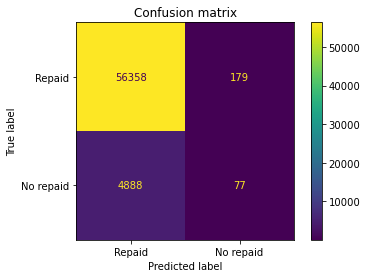

In [139]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

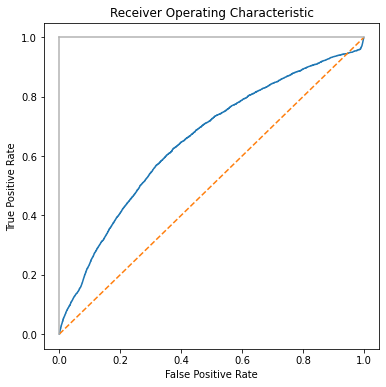

In [140]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

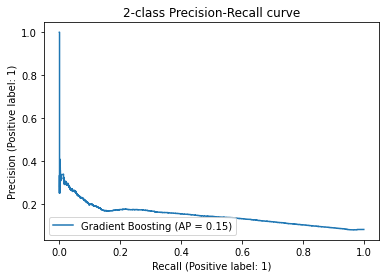

In [141]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="Gradient Boosting")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [142]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [143]:
df_temp = pd.DataFrame({
    "Model" : ["Tuned - Gradient Boosting"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [144]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3
5,Class weight - LightGBM,0.772,0.436,0.322,0.424,3.0
6,Tuned - Gradient Boosting,0.653,0.016,0.029,0.015,4.6


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. Modelisation using OverSampling</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the unbalanced class, we are going to implement OverSampling technique with SMOTE.</p>
</div>

In [18]:
smote = SMOTE(random_state=42, n_jobs=-1)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.1. Random Forest</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [23]:
clf_rf_os = imbpipeline(steps = [["Smote", smote],
                                 ["Random_Forest", RandomForestClassifier(**rf_parameters,
                                                                          random_state=42,
                                                                          n_jobs=-1)]
                                 ]
                        )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [25]:
start_time_model = timeit.default_timer()

clf_rf_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [26]:
y_pred = clf_rf_os.predict(X_test)
y_prob = clf_rf_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.18
- Best Score:		 0.395




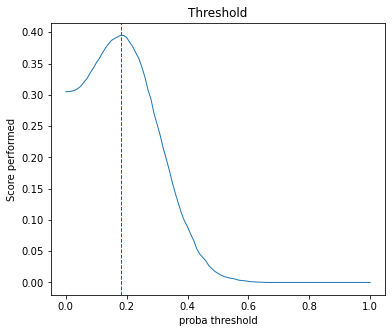

In [30]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [31]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

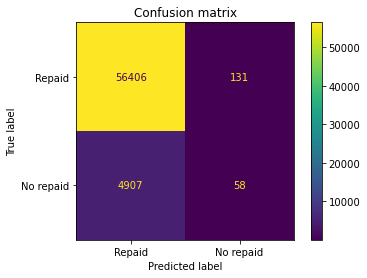

In [32]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

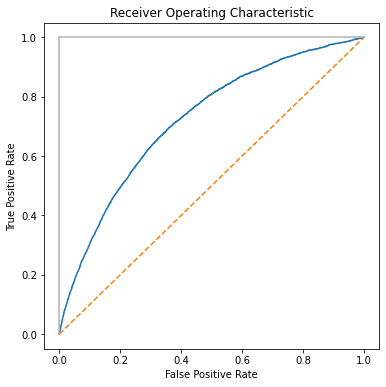

In [33]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

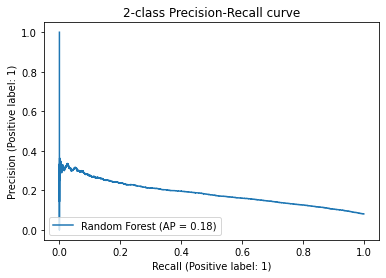

In [34]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="Random Forest")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [35]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [36]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - Random Forest"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [41]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3
5,Class weight - LightGBM,0.772,0.436,0.322,0.424,3.0
6,Tuned - Gradient Boosting,0.653,0.016,0.029,0.015,4.6
7,OverSampling - Random Forest,0.721,0.012,0.023,0.011,4.3


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.2. LightGBM</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [61]:
clf_lgbm_os = imbpipeline(steps = [["Smote", smote],
                                   ["Random_Forest", LGBMClassifier(**lgbm_parameters, learning_rate=0.02,
                                                                    colsample_bytree=0.9497036, subsample=0.8715623,
                                                                    reg_alpha=0.041545473, reg_lambda=0.0735294,
                                                                    min_split_gain=0.0222415, min_child_weight=39.3259775,
                                                                    random_state=42, n_jobs=-1)]
                                   ]
                          )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [62]:
start_time_model = timeit.default_timer()

clf_lgbm_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [63]:
y_pred = clf_lgbm_os.predict(X_test)
y_prob = clf_lgbm_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.06
- Best Score:		 0.436




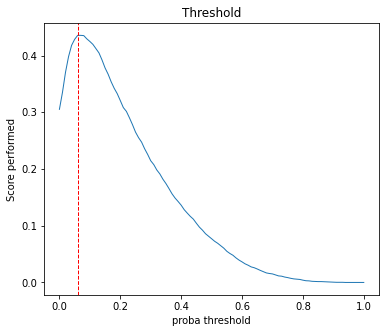

In [64]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [65]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

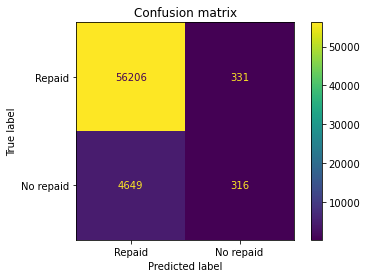

In [66]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

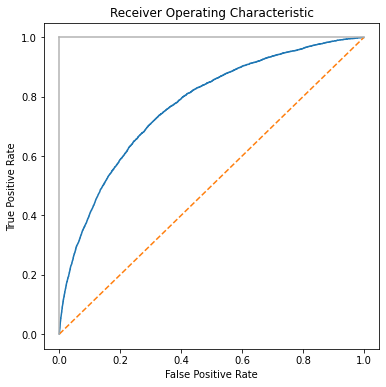

In [67]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

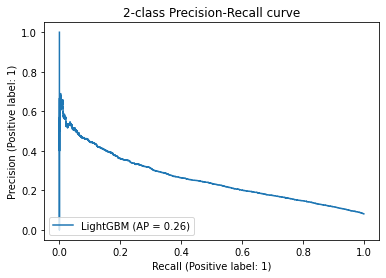

In [68]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="LightGBM")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [69]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [70]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - LightGBM"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [71]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3
5,Class weight - LightGBM,0.772,0.436,0.322,0.424,3.0
6,Tuned - Gradient Boosting,0.653,0.016,0.029,0.015,4.6
7,OverSampling - Random Forest,0.721,0.012,0.023,0.011,4.3
8,OverSampling - LightGBM,0.771,0.064,0.113,0.063,6.1


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.3. Gradient Boosting</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Unfortunately, Gradient Boosting (GBM) doesn't have a parameters call <b>class_weight</b> to treat with Imbalanced Class.</p>
    <p>But, GBM deals with class imbalance by constructing successive training sets based on incorrectly classified examples</p>
</div>

In [72]:
clf_gb_os = imbpipeline(steps = [["Smote", smote],
                                 ["Gradient Boosting", GradientBoostingClassifier(**gb_parameters,
                                                                                  validation_fraction=0.2, 
                                                                                  n_iter_no_change=5,
                                                                                  tol=0.01, random_state=42)]
                                ]
                       )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [73]:
start_time_model = timeit.default_timer()

clf_gb_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [74]:
y_pred = clf_gb_os.predict(X_test)
y_prob = clf_gb_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.04
- Best Score:		 0.375




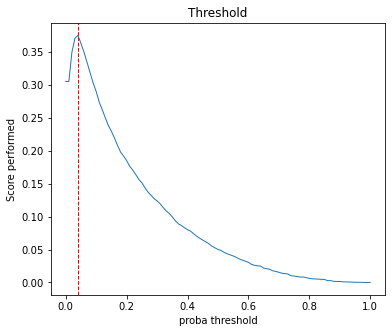

In [75]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [76]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

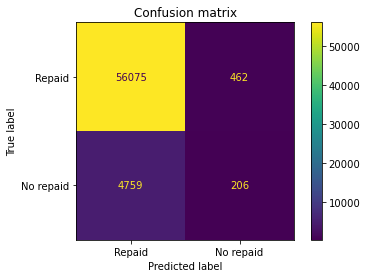

In [77]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

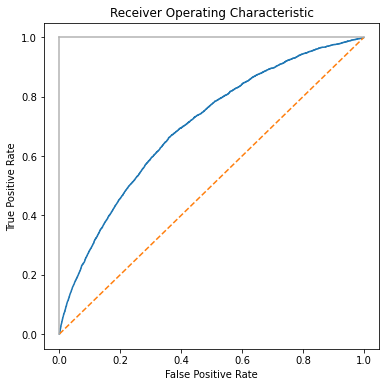

In [78]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

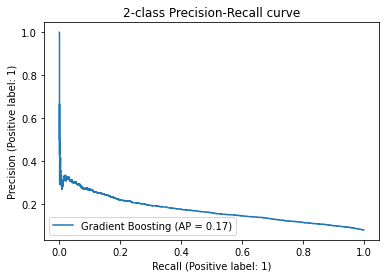

In [79]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="Gradient Boosting")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [80]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

In [81]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - Gradient Boosting"],
    "ROC-AUC" : roc_auc,
    "Recall" : recall,
    "F1" : f1,
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [82]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics.reset_index(drop=True)

,Model,ROC-AUC,Recall,F1,Custom Score,Duration
0,Dummy Classifier,0.500,0.000,0.000,NaN,0.0
1,Baseline - Random Forest,0.714,0.001,0.002,NaN,8.6
2,Baseline - LightGBM,0.773,0.033,0.062,NaN,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,NaN,28.3
4,Class weight - Random Forest,0.750,0.023,0.044,0.023,14.3
5,Class weight - LightGBM,0.772,0.436,0.322,0.424,3.0
6,Tuned - Gradient Boosting,0.653,0.016,0.029,0.015,4.6
7,OverSampling - Random Forest,0.721,0.012,0.023,0.011,4.3
8,OverSampling - LightGBM,0.771,0.064,0.113,0.063,6.1
9,OverSampling - Gradient Boosting,0.700,0.041,0.073,0.041,72.6


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">10. Feature selection</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to apply a Feature Selection on the best models results. To do that we are going to use two of the more popular methods</p>
    <ul style="list-style-type: square;">
        <li>Select the top k variables: SelectKBest</li>
        <li>Select the top percentile variables: SelectPercentile</li>
    </ul>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">10.1. SelectKBest</h3>
</div>

In [14]:
X = df_current_clients[TRAINING_COLUMNS]

In [15]:
y_target = df_current_clients.loc[:,"TARGET"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [17]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (246005, 506)
y_train: (246005,)
---------------------
X_test: (61502, 506)
y_test: (61502,)


<div style="background-color: red;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">----------- HERE -----------</h2>
</div>